# Acquire data from accelerometer from DAQ Board
## Callin Switzer
## python 3 (pyfly35 environment)
## 22 Jan 2017


Download nidaq driver for ni USB-6229 (save to thumb drive)

Download/update anaconda

download PyDAQmx

download pySerial (conda install pySerial)

upload code to Arduinos (001_Stepper_and_DCMotor)

# Setup

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from PyDAQmx import * #works with python 3.5 -- need to install NiDACmx (takes like a day to download)

In [3]:

import PyCapture2 as fc2
from sys import exit

In [4]:
import serial # works

In [5]:
import cv2
print(cv2.__version__)


3.3.0


In [6]:
import time

import os
import peakutils 
import msvcrt
import winsound
import shutil
import pandas as pd

import skimage.io as io
import sys
from datetime import datetime
import glob

print(sys.version)


now = datetime.now()
print("last run on " + str(now))

3.5.4 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:15:17) [MSC v.1900 64 bit (AMD64)]
last run on 2018-02-02 09:35:50.302554


In [7]:
 # % qtconsole

In [8]:
# list ports

def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result


# I'm using COM3 and COM5 arduinos
# COM4 is for the arduino controlling the cameras
serial_ports()

['COM3', 'COM5']

In [9]:
PORT1 = "COM3"
connected1 = False
ser1 = serial.Serial(PORT1,115200)
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)

connected to arduino on COM3


In [10]:
PORT2 = "COM5"
connected2 = False
ser2 = serial.Serial(PORT2,115200)
while not connected2:
    serin2 = ser2.read()
    connected2 = True
    print("connected to arduino on " + PORT2)

connected to arduino on COM5


In [11]:
# stepper only
written = ser1.write("s".encode("utf-8"))
written = ser2.write("s".encode("utf-8"))

In [12]:
# vibration motor only
written = ser1.write("v".encode("utf-8"))
written = ser2.write("v".encode("utf-8"))

In [1596]:
# both motors
written = ser1.write("sv".encode("utf-8"))
written = ser2.write("sv".encode("utf-8"))

In [14]:
class accelDta:
    
    '''read accelerometer data, fft, and plot'''
    
    def __init__(self, accNum = "Dev2/ai0", N_samples = 20000, log_rate = 200000.0):
        self.data = np.zeros((N_samples,), dtype=np.float64)
        self.N_samples = N_samples
        self.log_rate = log_rate
        self.read = int32()
        self.accNum = accNum
    
    
    def readAccel(self, ): 
        taskHandle = TaskHandle()

        DAQmxCreateTask("", byref(taskHandle))
        # I have an piezoelectric accelerometer pluged into channel ai1 with range +/-10V
        DAQmxCreateAIVoltageChan(taskHandle, self.accNum, 
                                 "Accelerometer", DAQmx_Val_Diff, 
                                 -10.0, 10.0, DAQmx_Val_Volts, None)
        DAQmxCfgSampClkTiming(taskHandle, "", self.log_rate, 
                              DAQmx_Val_Rising, 
                              DAQmx_Val_FiniteSamps, self.N_samples)

        DAQmxStartTask(taskHandle)
        DAQmxReadAnalogF64(taskHandle, self.N_samples, 10.0, 
                           DAQmx_Val_GroupByChannel, self.data, 
                           self.N_samples, byref(self.read), None)

        if taskHandle:
            DAQmxStopTask(taskHandle);
            DAQmxClearTask(taskHandle);
            
        # get amplitude    
        self.amp = np.max(self.data) - np.min(self.data)

    def FFT(self, fmin = 20, fmax= 450):
        n =int(len(self.data))
        k = np.arange(n, step = 1)
        T = n/self.log_rate
        frq = k/T # two sides frequency range
        frq = frq[range(int(n/2))] # one side frequency range

        # trim frq
        keepInd = (frq > fmin) & (frq < fmax)
        frqKeep = frq[keepInd]

        Y = np.fft.fft(self.data)/n # fft computing and normalization
        Y = Y[range(int(n/2))]

        # remove Y that is outside the frequency rang of interest
        Ykeep = Y[keepInd]



        # calculate top frequency
        ind = np.argpartition(abs(Ykeep), -4)[-4:]
        # Find highest point on the spectrum
        peakFrq = frqKeep[ind[::-1]]
        pwr = (abs(Ykeep)[ind[::-1]])

        domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

        domPkPwr = pwr[peakFrq == domPK]

        self.frq = frq
        self.peakFrq = peakFrq
        self.pwr = pwr
        self.domPK = domPK
        self.domPkPwr = domPkPwr 
        self.Y = Y
        


    def plotFFT(self, fmin =0, fmax = 1000, reward = 'F'):
         # create subplot 1
        ax1 = plt.subplot(121)
        ax1.plot(np.array(range(len(self.data)))/ float(self.log_rate), self.data)
        ax1.set_ylabel("Volts")
        ax1.set_xlabel("time (s)")
        if reward == 'T':
            ax1.set_facecolor('grey')

        # create subplot 2
        ax2 = plt.subplot(122)
        ax2.plot(self.frq,abs(self.Y),'r')
        ax2.plot(self.peakFrq,self.pwr, 'ro')
        ax2.set_xlim(fmin, fmax)
        ax2.set_ylabel('power')
        ax2.set_xlabel('frequency')
        ax2.plot(self.domPK, self.domPkPwr,'o', color = 'black', markersize = 5)
        ax2.annotate(str(self.domPK) + ' Hz', 
                     xy=(self.domPK, self.domPkPwr), 
                     xytext=(self.domPK + 40, 
                             self.domPkPwr- 0.0001), size = 12)
        plt.tight_layout()
        plt.show()
        




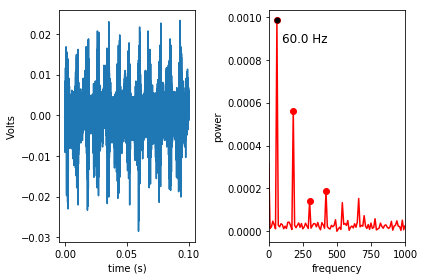

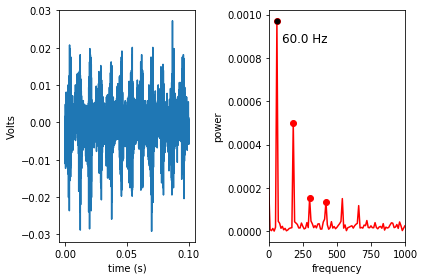

[None, None]

In [15]:
# test accelerometers
acc1 = accelDta("Dev2/ai0")
acc2 = accelDta("Dev2/ai1")
[j.readAccel() for j in [acc1, acc2]]
[k.FFT() for k in [acc1, acc2]]
[kk.plotFFT() for kk in [acc1, acc2]]

In [16]:
## read in data, and take a photo if accel power is high enough
class processAndReward:
    
    '''Process data and reward bee if the bee meets the criteria
       Save amplitude, frequency information
    '''
    
    def __init__(self, ampThresh = 0.07, accNum1 = "Dev2/ai0", 
                 accNum2= "Dev2/ai1", rewardMin = 220, rewardMax = 450, 
                reward1 = True, reward2 = True, saveDirectory = "C:\\Users\\Combes4\\Desktop"):
        self.ampThresh = ampThresh
        acc1 = accelDta(accNum1)
        acc2 = accelDta(accNum2)
        self.rewardMin = rewardMin
        self.rewardMax = rewardMax
        self.reward1 = reward1
        self.reward2 = reward2
        self.saveDirectory = saveDirectory
        self.startTime = str(datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
        self.treatment = accNum1 + "_" + str(reward1) +  "__" + accNum2 + "_" + str(reward2)
        self.LastVisitTime = time.time()
        self.rewardCounter = 0
           
        # open file and write header
        self.f = open(os.path.join(self.saveDirectory, self.startTime + ".csv"), 'a')
        header = "Amp_V"+ "," +  "freq_Hz"+ "," +  "accNum"+ "," + "rewardStatus" + "," +  "timestamp" + "," + "treatment" +  "\n"
        self.f.write(header)
        
    def saveAmpFreq(self, accNum):
        var1 = (str(accNum.amp) + "," + 
                str(accNum.domPK) + "," 
                + accNum.accNum + ","+ str(self.rewardYesNo) + "," +
                str(datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3])+ "," +
                self.treatment + 
                '\n')
        self.f.write(var1)
      
        
    # if frequency is in a certain range, deliver reward
    def reward(self, gg = acc1, serialPort = ser2, reward = True):
        self.rewardYesNo = reward
        if((gg.domPK > self.rewardMin) and (gg.domPK < self.rewardMax) and (gg.amp > self.ampThresh)):
            written = serialPort.write("s".encode("utf-8"))
            written = serialPort.write("v".encode("utf-8"))
            self.saveAmpFreq(gg)
            print(gg.amp, gg.accNum)
            gg.plotFFT()
            return(True)
        else:
            return(False)
        
    def procReward(self):
        # read in data
        [j.readAccel() for j in [acc1, acc2]]
        
        # only go on if the reading is above amplitude cutoff
        # refref should adjust this, based on acc sensitivity
        if((acc1.amp > self.ampThresh) or (acc2.amp > self.ampThresh)):
            
            
            # calculate fft
            [k.FFT() for k in [acc1, acc2]]
            
            # only proceed if fft signal is strong
            if (acc1.domPkPwr > 0.001) or (acc2.domPkPwr > 0.001):
        
                # reward only one accel at once
                if(acc1.amp > acc2.amp):
                    if self.reward(acc1, ser2, reward = self.reward1):
                        self.rewardCounter += 1
                        self.LastVisitTime = time.time()
                else:
                    if self.reward(acc2, ser1, reward = self.reward2):
                        self.rewardCounter +=1
                        self.LastVisitTime = time.time()
                


In [17]:
str(np.random.choice(["1:True, 2:False", "1:False, 2:True"], 1))

"['1:False, 2:True']"

In [ ]:
while msvcrt.kbhit():
    msvcrt.getch()
    print('clearing characters ...')

# instantiate
procR = processAndReward(reward1 = True, reward2 = False, saveDirectory = "C:\\Users\\Combes4\\Desktop\\temp3\\")

# start timer

timeOUT = 5.0 * 60 # seconds
close = False


while(True):
    procR.procReward()

    # break loop if someone presses the 'q' while in terminal
    if msvcrt.kbhit():
        if msvcrt.getch() == b'q':
            close = True
            print("keyboard q pressed")
            
    elif (time.time() - procR.LastVisitTime  > timeOUT):
        close = True
        print("time out")
        
    elif (procR.rewardCounter >= 100):
        close = True
        print("reached 100 rewards")
        
    if close:
        procR.f.close()
        print('now quitting loop')
        for i in range(5):
            winsound.Beep(450,100)
        break
        
       
       

In [ ]:
print(procR.f.name)
print("reward1" + str(procR.reward1) + "_reward2" + str( procR.reward2))


In [ ]:
# post-processing add hive info
# refref: add video info
colonyNum = 1
IT_span = 3.78 # in mm

# add hive to csv file
fname = procR.f.name
#fname = "C:\\Users\\Combes4\\Desktop\\temp3\\2018_01_29__16_06_39_075.csv"

csv_input = pd.read_csv(fname)
csv_input['colonyNum'] = colonyNum
csv_input['ITSpan_mm'] = IT_span
csv_input['Notes'] = "NA"
csv_input.to_csv(fname, index=False)
csv_input.head()

--- END ---

In [ ]:
time.time() - startTime > timeoutTime

In [ ]:
procR.f.closed

In [ ]:
# refref try to start cameras asynchronously

In [ ]:
# close all files in directory
saveDir = "C:\\Users\\Combes4\\Desktop\\temp3\\"
os.listdir(saveDir)

file_list = [os.path.join(saveDir + ii) for ii in os.listdir(saveDir)]
file_list

In [ ]:
file_handles = []
try:
    for file in file_list:
        file_handles.append(open(file))

    # Do some calculations with open files

finally:
    for fh in file_handles:
        fh.close()
        print(fh.closed)

In [ ]:
ff = open('C:\\Users\\Combes4\\Desktop\\temp3\\2018_01_26__13_01_37_956.csv', 'a')
ff.close()
ff.closed

In [ ]:
procR = processAndReward(reward1 = True, reward2 = False, saveDirectory = "C:\\Users\\Combes4\\Desktop\\temp3\\")

In [ ]:
saveDirectory = "C:\\Users\\Combes4\\Desktop\\temp3\\"

procR.saveAmpFreq(acc1)

In [ ]:
procR.f.close()

In [ ]:
saveDirectory = "C:\\Users\\Combes4\\Desktop\\temp3\\"
f = open(saveDirectory + 'foo.txt', 'a')
f.close()

In [ ]:
# instantiate
procR = processAndReward()
procR.procReward()

In [ ]:
## try multiprocessing

In [ ]:
import multiprocessing

In [ ]:

def f(x):
    return x*x


p = multiprocessing.Process(target=f, args=(1,2,3,34))
p.start()

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool

In [ ]:
# multiprocessing examples
# looks like I can actually only read one acc at a time.

x = ["Dev2/ai0","Dev2/ai1"]

def foo(ii): 
    tmp = accelDta(ii)
    tmp.readAccel()
pool = ThreadPool(2)
start = time.time()
results = pool.map(foo, x)
print("4 thread pool took {} seconds".format(time.time() - start))

In [ ]:
# compare to for loop
start = time.time()
for jj in x:
    print(jj)
    foo(jj)
print("1 thread pool took {} seconds".format(time.time() - start))

In [ ]:
foo('Dev2/ai1')

In [ ]:
# define function for recording and rewarding buzzes
def recRew(ftestMin, ftestMax, trt):
     
        
    aThr = [0,5]
    
    # loop to look for specific frequencies
    fmin = 5.0
    fmax = 520.0

    counterAlarm = 50

    peakFrq = np.array(0)
    pwr = np.array(0)
    pwrCutoff = 0.004 # lower amplitude cutoff
    sleepTime = 0 # seconds

    # make a continuously-sampling loop that will end if it gets a frequency of 280 Hz
    # 100000 samples is one second
    # Note: to get higher resolution for peak freq, I'd need a larger window
    N_samples = 20000 
    log_rate = 200000.0

    ctr = 0
    ctr2 = 0
    
    # start buzz timer
    buzzTime = time.time()
    
    # open text file
    with open(str(outDir)+ '_ampFreq.txt', 'a') as text_file:  

        # clear characters waiting to be read
        while msvcrt.kbhit():
            msvcrt.getch()
            print('clearing characters ...')

        while ctr <= (2*counterAlarm - 1): # only give a max of 100 buzzes
                
            taskHandle = TaskHandle()
            read = int32()
            data = np.zeros((N_samples,), dtype=np.float64)

            DAQmxCreateTask("", byref(taskHandle))
            # I have an piezoelectric accelerometer plugged into channel ai1 with range +/-10V
            DAQmxCreateAIVoltageChan(taskHandle, "Dev1/ai0", 
                                     "Accelerometer", DAQmx_Val_Diff, 
                                     -10.0, 10.0, DAQmx_Val_Volts, None)
            DAQmxCfgSampClkTiming(taskHandle, "", log_rate, 
                                  DAQmx_Val_Rising, 
                                  DAQmx_Val_FiniteSamps, N_samples)

            DAQmxStartTask(taskHandle)
            DAQmxReadAnalogF64(taskHandle, N_samples, 10.0, 
                               DAQmx_Val_GroupByChannel, data, 
                               N_samples, byref(read), None)

            if taskHandle:
                DAQmxStopTask(taskHandle);
                DAQmxClearTask(taskHandle);

            # 20fft
            n =len(data) # length of the signal
            k = np.arange(n, step = 1)
            T = n/log_rate
            frq = k/T # two sides frequency range
            frq = frq[range(n/2)] # one side frequency range

            Y = np.fft.fft(data)/n # fft computing and normalization
            Y = Y[range(n/2)]

            # calculate top frequency
            ind = np.argpartition(abs(Y), -4)[-4:]
            # Find highest point on the spectrum
            peakFrq = frq[ind[::-1]]
            pwr = (abs(Y)[ind[::-1]])
            domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

            beeFrqPwr = pwr[peakFrq == domPK]
            # print beeFrq in peakFrq, peakFrq[pwr == max(pwr)], beeFrqPwr, beeFrqPwr > 0.3

            # if the bee is vibrating at a high enough power and the dominant peak from the 
            # vibration is in the right range
            if beeFrqPwr > pwrCutoff and domPK > fmin and domPK < fmax:
                buzzTime = time.time()
                
                reward = 'F'

                aamp = np.max(data) - np.min(data)
                # write value to serial port, and get it to start the turn on the motor
                s3 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
                print(s3 + " topFreq = " + str(domPK) + " amp = " + str(aamp))

                                
                # take a photo and save it
                im = fc2.Image()
                c.retrieve_buffer(im)
                a = np.array(im)
                cv2.imwrite(os.getcwd() + '\\' + outDir + '\\' + s3 + '.pgm', a) # .pgm / ppm is quite fast, and can be read by imageJ
                
                
                #print reward number
                print('Counter Number ' + str(ctr))
                
                # reward only give pollen at specific frequencies and ampliude threshold
                if domPK > ftestMin and domPK < ftestMax and (aThr[0] < aamp < aThr[1]):
                                    
                    ctr = ctr + 1
                    
                    if (trt == 1) and (ctr <= counterAlarm):
                        written = ser1.write("20")
                        reward = 'T'
                        
                    if (trt == 2) and (ctr > counterAlarm):
                        written = ser1.write("20")
                        reward = 'T'

                    # beep for end of program
                    if ctr > counterAlarm - 5:
                        for i in range(counterAlarm - ctr):
                            winsound.Beep(400,100)

                    if ctr > counterAlarm:
                        for i in range(counterAlarm - ctr):
                            winsound.Beep(400,500)

                ############################### PLOT ##################################
                # create subplot 1
                ax1 = plt.subplot(211)
                ax1.plot(np.array(range(len(data)))/ float(log_rate), data)
                ax1.set_ylabel("Volts")
                ax1.set_xlabel("time (s)")
                if reward == 'T':
                    ax1.set_facecolor('grey')

                # create subplot 2
                ax2 = plt.subplot(212)
                ax2.plot(frq,abs(Y),'r')
                ax2.plot(domPK, beeFrqPwr, 'ro')
                ax2.set_xlim(20, 1000)
                ax2.set_ylabel('power')
                ax2.set_xlabel('frequency')
                plt.tight_layout()
                plt.show()


                #################### SAVE FILE FROM ACCEL ##############################
                np.savetxt((os.getcwd() + '\\' + outDir + '\\' + s3 + '_' + str(ftestMin) + '_' + 
                           str(ftestMax) + '_' + str(aThr[0]) + '_' +  str(aThr[1]) + '.txt'), 
                           (np.array(range(len(data)))/ float(log_rate), data), delimiter = ' ')

                ### write frequency and amplitude to file
                var1 = (str(domPK) + ', ' + 
                           str(round(np.max(data) - np.min(data), 5)) + ', ' + 
                           s3 + ', ' + str(ctr) +', ' + str(reward) + 
                        ',' + str(aThr[0]) + 
                        ',' + str(aThr[1]) + '\n')
                text_file.writelines(var1)

                # sleep
                time.sleep(sleepTime)
            
            else:
                #take a photo every 5 loops
                # take a photo and save it
                if ctr2 % 5 == 0:
                    s4 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
                    im = fc2.Image()
                    c.retrieve_buffer(im)
                    a = np.array(im)
                    cv2.imwrite(os.getcwd() + '\\' + outDir + '\\' + s4 + "_bkg" + '.pgm', a) # .pgm / ppm is quite fast, and can be read by imageJ

                ctr2 += 1
            

            # break loop if someone presses the 'q' while in terminal
            if msvcrt.kbhit():
                if msvcrt.getch() == 'q':
                    # disconnect camera 
                    c.stop_capture()
                    c.disconnect()
                    print('keyboard q pressed, now quitting loop')
                    for i in range(5):
                        winsound.Beep(450,100)
                    break   
                else:
                    written = ser1.write("20")
            
           # print(time.time() - buzzTime)
            
            # if bee goes for 5 minutes without buzzing, end the loop
            if time.time() - buzzTime > (5.0 * 60):
                # disconnect camera 
                c.stop_capture()
                c.disconnect()
                print('Bee Stopped buzzing, now quitting loop')
                for i in range(5):
                    winsound.Beep(450,100)
                break   
                    
            ## move file to new folder at end of loop!

    # make sound when loop stops
    for i in range(3):
        winsound.Beep(350,500)

In [ ]:
## reward amplitudes
rewAAmp = "test" # test rewards at any amplitude and freq's between 220 and 450

# change python directory to Dropbox
os.chdir("C:\\Users\Combes4\Desktop\Temp2")
os.getcwd()

# make new directory with date, if it doesn't already exist
outDir = (datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
#outDir = 'accelShake_009_05092016'

if not os.path.isdir(os.getcwd() + '\\' + outDir):
    os.mkdir(os.getcwd() + '\\' + outDir)
    
    print( 'new directory created: ' + str(outDir))
else: print( 'directory exists: '  + str(outDir))

print( "the current python direcory is " + str(os.getcwd()))
                                                                                                                 
# make new file
open(str(outDir)+ '_ampFreq.txt', 'a').close()

# start camera -- point grey Chameleon
c = fc2.Camera()
c.connect(bus.getCameraFromIndex(0))
c.startCapture()

# capture a background image (may be useful for image subtraction)
im = grabImages(c, 1)
im.save((os.getcwd() + '\\' + outDir + '\\' + "fc2TestImage.png").encode("utf-8"), fc2.IMAGE_FILE_FORMAT.PNG)
#cv_image = np.array(img.getData(), dtype="uint8").reshape( (img.getRows(), img.getCols()) );

#cv2.imwrite(os.getcwd() + '\\' + outDir + '\\' + 'background.pgm', a) 

# change treatment each trial (randomly)
ttrt =99999 #int(np.random.choice([1,2], size = 1))
print(ttrt)

recRew(trt =ttrt, ftestMin=220, ftestMax =450)

In [ ]:
## make new folder and move files into that folder
hhive = '8'
ddate = (datetime.datetime.now().strftime("%Y_%m_%d"))

if 'bn' in globals():
    bn += 1
else:
    bn = 282

BeeNum = str(bn)



if (ttrt == 2):
    treatment = "RewSec"
elif (ttrt == 1):
    treatment = "RewFir"

finFolder = 'B_' + BeeNum + '_' + ddate + '_H_'+  hhive + '_' + treatment

# make new folder if it doesn't exist
if not os.path.isdir(os.getcwd() + '\\' + finFolder):
    os.mkdir(os.getcwd() + '\\' + finFolder)
    
    # move files into new folder
    #os.rename(os.getcwd() + '\\' + outDir, os.getcwd() + '\\' + outDir +'\\' + finFolder)
    os.rename(os.getcwd() + '\\' + outDir + '_ampFreq.txt', os.getcwd() + '\\' + finFolder + '\\' + outDir + '_ampFreq.txt')
    
    # move folder to new folder
    src = os.getcwd() + '\\' + outDir
    dst = os.getcwd() + '\\'  + finFolder + '\\'+ outDir
    shutil.move(src, dst)
    
else: 
    print 'directory already exists'


    
# calculate mean frequency (only for rewarded buzzes)
ff = os.getcwd() + '\\' + finFolder + '\\' + outDir + '_ampFreq.txt'
dd = pd.read_csv(ff, header = None)

print "beeNum " + str(bn)

dd2 = dd[(dd.ix[:,0] > 220) & (dd.ix[:,0] < 450)]


print "total rewards"
print np.sum(np.array(dd2.ix[:,4]) == " T")

# print "total buzzes"
# print len(dd2)

print "mean Freq rewarded"
print np.mean(dd2.ix[:,0][dd2.ix[:,4] == " T"])

print "total buzzes not rewarded"
print np.sum(np.array(dd2.ix[:,4]) == " F")

print "mean Freq Unrewarded"
print np.mean(dd2.ix[:,0][dd2.ix[:,4] == " F"])

# save metadata to file
metadataFile = (datetime.datetime.now().strftime("%Y_%m_%d")) + '_metadata.csv'

# make new file if it doesn't exist (with header)
if not os.path.isfile(metadataFile):
    with open(metadataFile, 'a') as the_file:
        the_file.write('timeOfTrial,beeNum,treatment,folder,totalRewards,meanFreqRewarded,totalBuzzesNotRewarded,meanFreqUnrewarded')
        the_file.write('\n')
else: 
    print 'file already exists -- adding to file'

# now write data to file                       
with open(metadataFile, 'a') as the_file:
    the_file.write(outDir + ',' + str(bn) + ','+
                   treatment + ',' + 
                   finFolder + ',' + 
                   str(np.sum(np.array(dd2.ix[:,4]) == " T")) + ',' + 
                  str(np.mean(dd2.ix[:,0][dd2.ix[:,4] == " T"])) + ',' + 
                  str(np.sum(np.array(dd2.ix[:,4]) == " F")) + ',' +
                  str(np.mean(dd2.ix[:,0][dd2.ix[:,4] == " F"]))
                  )
    the_file.write('\n')                 


In [ ]:
# calculate mean frequency (only for rewarded buzzes)
ff = os.getcwd() + '\\' + finFolder + '\\' + outDir + '_ampFreq.txt'
dd = pd.read_csv(ff, header = None)

print "beeNum " + str(bn)

dd2 = dd[(dd.ix[:,0] > 220) & (dd.ix[:,0] < 450)]


print "total rewards"
print np.sum(np.array(dd2.ix[:,4]) == " T")

# print "total buzzes"
# print len(dd2)

print "mean Freq rewarded"
print np.mean(dd2.ix[:,0][dd2.ix[:,4] == " T"])

print "total buzzes not rewarded"
print np.sum(np.array(dd2.ix[:,4]) == " F")

print "mean Freq Unrewarded"
print np.mean(dd2.ix[:,0][dd2.ix[:,4] == " F"])

# save metadata to file
metadataFile = (datetime.datetime.now().strftime("%Y_%m_%d")) + '_metadata.csv'

# make new file if it doesn't exist (with header)
if not os.path.isfile(metadataFile):
    with open(metadataFile, 'a') as the_file:
        the_file.write('timeOfTrial,beeNum,treatment,folder,totalRewards,meanFreqRewarded,totalBuzzesNotRewarded,meanFreqUnrewarded')
        the_file.write('\n')
else: 
    print 'file already exists -- adding to file'

# now write data to file                       
with open(metadataFile, 'a') as the_file:
    the_file.write(outDir + ',' + str(bn) + ','+
                   treatment + ',' + 
                   finFolder + ',' + 
                   str(np.sum(np.array(dd2.ix[:,4]) == " T")) + ',' + 
                  str(np.mean(dd2.ix[:,0][dd2.ix[:,4] == " T"])) + ',' + 
                  str(np.sum(np.array(dd2.ix[:,4]) == " F")) + ',' +
                  str(np.mean(dd2.ix[:,0][dd2.ix[:,4] == " F"]))
                  )
    the_file.write('\n')                 


In [ ]:
print "total rewards"
np.sum(np.array(dd2.ix[:,4]) == " T")

In [ ]:
print "total buzzes"
len(dd2)

In [ ]:
plt.hist(np.array(dd2.ix[:,0]), bins = 20)

In [ ]:
np.array(dd2.ix[:,0])

In [ ]:
# get file list in directory
fllist = os.listdir(os.getcwd() + '//' + outDir)

fpth = [os.getcwd() + '//' + outDir + '//' + ii for ii in fllist]    

sust = [os.access(kk, os.W_OK) for kk in fpth]

print "num read only files = " + str( np.sum(not sust))


In [ ]:
print fc2.get_library_version()
c = fc2.Context()
print c
print c.get_num_of_cameras()

In [ ]:
import shutil

In [ ]:
src = os.getcwd() + '\\' + outDir
dst = os.getcwd() + '\\'  + finFolder + '\\'+ outDir
shutil.move(src, dst)

In [ ]:
os.getcwd() + '\\' + outDir

In [ ]:
# make a continuously-sampling loop that will end if it gets a frequency of 280 Hz
# 100000 samples is one second
# Note: to get higher resolution for peak freq, I'd need a larger window
N_samples = 20000 
log_rate = 200000.0

ctr = 0


taskHandle = TaskHandle()
read = int32()
data = np.zeros((N_samples,), dtype=np.float64)

DAQmxCreateTask("", byref(taskHandle))
# I have an piezoelectric accelerometer plugged into channel ai1 with range +/-10V
DAQmxCreateAIVoltageChan(taskHandle, "Dev1/ai0", 
                         "Accelerometer", DAQmx_Val_Diff, 
                         -10.0, 10.0, DAQmx_Val_Volts, None)
DAQmxCfgSampClkTiming(taskHandle, "", log_rate, 
                      DAQmx_Val_Rising, 
                      DAQmx_Val_FiniteSamps, N_samples)

DAQmxStartTask(taskHandle)
DAQmxReadAnalogF64(taskHandle, N_samples, 10.0, 
                   DAQmx_Val_GroupByChannel, data, 
                   N_samples, byref(read), None)

if taskHandle:
    DAQmxStopTask(taskHandle);
    DAQmxClearTask(taskHandle);

# fft
n = len(data) # length of the signal
k = np.arange(n)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(data)/n # fft computing and normalization
Y = Y[range(n/2)]

# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

beeFrqPwr = pwr[peakFrq == domPK]
# print beeFrq in peakFrq, peakFrq[pwr == max(pwr)], beeFrqPwr, beeFrqPwr > 0.3

# if the bee is vibrating at a high enough power and the dominant peak from the 
# vibration is in the right range

reward = 'F'

aamp = np.max(data) - np.min(data)
# write value to serial port, and get it to start the turn on the motor
s3 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
print(s3 + " topFreq = " + str(domPK) + " amp = " + str(aamp))

# reward only give pollen at specific frequencies and ampliude threshold
############################### PLOT ##################################
# create subplot 1
ax1 = plt.subplot(211)
ax1.plot(np.array(range(len(data)))/ float(log_rate), data)
ax1.set_ylabel("Volts")
ax1.set_xlabel("time (s)")
if reward == 'T':
    ax1.set_facecolor('grey')

# create subplot 2
ax2 = plt.subplot(212)
ax2.plot(frq,abs(Y),'r')
ax2.plot(domPK, beeFrqPwr, 'ro')
ax2.set_xlim(20, 1000)
ax2.set_ylabel('power')
ax2.set_xlabel('frequency')
plt.tight_layout()
plt.show()

In [ ]:
data

In [ ]:
# fft
n = len(data) # length of the signal
k = np.arange(n)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(data)/n # fft computing and normalization

In [ ]:
Y = Y[range(n/2)]

In [ ]:
ps = np.abs(np.fft.fft(data))**2

time_step = 1/100000000.0
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

ax2 = plt.subplot(212)
ax2.plot(freqs[idx] / 1000, ps[idx],'r')
ax2.set_xlim(420, 450)

In [ ]:
freqs

In [ ]:
# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

In [ ]:
Y

In [ ]:
# change python directory to desktop
os.chdir('C:\\Users\\Combes4\\Desktop\\')
os.getcwd()

# make new directory with date, if it doesn't already exist
outDir = (datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
#outDir = 'accelShake_009_05092016'

if not os.path.isdir(os.getcwd() + '\\' + outDir):
    os.mkdir(os.getcwd() + '\\' + outDir)
    print 'new directory created: ' + str(outDir)
else: print 'directory exists: '  + str(outDir)

print "the current python direcory is " + str(os.getcwd())

# make new file
open(str(outDir)+ '_ampFreq.txt', 'a').close()

In [ ]:
# change python directory to desktop
os.chdir('C:\\Users\\Combes4\\Desktop\\')                    
os.getcwd()

# make new directory with date, if it doesn't already exist
outDir = (datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
#outDir = 'accelShake_009_05092016'

if not os.path.isdir(os.getcwd() + '\\' + outDir):
    os.mkdir(os.getcwd() + '\\' + outDir)
    print 'new directory created: ' + str(outDir)
else: print 'directory exists: '  + str(outDir)

print "the current python direcory is " + str(os.getcwd())


## alternative, increasing amplitude version

# loop to look for specific frequencies
fmin =5
fmax = 450

ftestMin = 220
ftestMax = 450

ampThresh = 0.0

counterAlarm = 30

peakFrq = np.array(0)
pwr = np.array(0)
pwrCutoff = 0.004
sleepTime = 0 # seconds

# make a continuously-sampling loop that will end if it gets a frequency of 280 Hz
# 100000 samples is one second
# Note: to get higher resolution for peak freq, I'd need a larger window
N_samples = 10000 
log_rate = 100000.0

ctr = 0

# open text file
with open(str(outDir)+ '_ampFreq.txt', 'a') as text_file:  

    # clear characters waiting to be read
    while msvcrt.kbhit():
        msvcrt.getch()
        print 'clearing characters ...'

    while True:
        taskHandle = TaskHandle()
        read = int32()
        data = np.zeros((N_samples,), dtype=np.float64)

        DAQmxCreateTask("", byref(taskHandle))
        # I have an piezoelectric accelerometer plugged into channel ai1 with range +/-10V
        DAQmxCreateAIVoltageChan(taskHandle, "Dev1/ai0", 
                                 "Accelerometer", DAQmx_Val_Diff, 
                                 -10.0, 10.0, DAQmx_Val_Volts, None)
        DAQmxCfgSampClkTiming(taskHandle, "", log_rate, 
                              DAQmx_Val_Rising, 
                              DAQmx_Val_FiniteSamps, N_samples)

        DAQmxStartTask(taskHandle)
        DAQmxReadAnalogF64(taskHandle, N_samples, 10.0, 
                           DAQmx_Val_GroupByChannel, data, 
                           N_samples, byref(read), None)

        if taskHandle:
            DAQmxStopTask(taskHandle);
            DAQmxClearTask(taskHandle);

        # fft
        n = len(data) # length of the signal
        k = np.arange(n)
        T = n/log_rate
        frq = k/T # two sides frequency range
        frq = frq[range(n/2)] # one side frequency range

        Y = np.fft.fft(data)/n # fft computing and normalization
        Y = Y[range(n/2)]

        # calculate top frequency
        ind = np.argpartition(abs(Y), -4)[-4:]
        # Find highest point on the spectrum
        peakFrq = frq[ind[::-1]]
        pwr = (abs(Y)[ind[::-1]])
        domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

        beeFrqPwr = pwr[peakFrq == domPK]
        # print beeFrq in peakFrq, peakFrq[pwr == max(pwr)], beeFrqPwr, beeFrqPwr > 0.3

        # if the bee is vibrating at a high enough power and the dominant peak from the 
        # vibration is in the right range
        if beeFrqPwr > pwrCutoff and domPK > fmin and domPK < fmax:
            reward = 'F'
            
            aamp = np.max(data) - np.min(data)
            # write value to serial port, and get it to start the turn on the motor
            s3 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
            print(s3 + " topFreq = " + str(domPK) + " amp = " + str(aamp))
            
            # reward only give pollen at specific frequencies and ampliude threshold
            if domPK > ftestMin and domPK < ftestMax and aamp > ampThresh:
                written = ser1.write("20")
                ctr = ctr + 1
                print('reward ' + str(ctr))
                reward = 'T'
                ampThresh = ampThresh + 0.02
                
                # beep for end of program
                if ctr > counterAlarm - 5:
                    for i in range(counterAlarm - ctr):
                        winsound.Beep(400,100)

                if ctr > counterAlarm:
                    for i in range(counterAlarm - ctr):
                        winsound.Beep(400,500)

            ############################### PLOT ##################################
            # create subplot 1
            ax1 = plt.subplot(211)
            ax1.plot(np.array(range(len(data)))/ float(log_rate), data)
            ax1.set_ylabel("Volts")
            ax1.set_xlabel("time (s)")

            # create subplot 2
            ax2 = plt.subplot(212)
            ax2.plot(frq,abs(Y),'r')
            ax2.plot(domPK, beeFrqPwr, 'ro')
            ax2.set_xlim(20, 1000)
            ax2.set_ylabel('power')
            ax2.set_xlabel('frequency')
            plt.tight_layout()
            plt.show()


            #################### SAVE FILE FROM ACCEL ##############################
            np.savetxt(os.getcwd() + '\\' + outDir + '\\' + s3+ '_' + str(ftestMin) + '_' + str(ftestMax) + '.txt', 
                       (np.array(range(len(data)))/ float(log_rate), data), delimiter = ' ')

            ### write frequency and amplitude to file on desktop
            var1 = str(domPK) + ', ' + str(round(np.max(data) - np.min(data), 5)) + ', ' + s3 + ', ' + str(ctr) +', ' + str(reward) + ', '+ str(ampThresh) + '\n'
            text_file.writelines(var1)

            # sleep
            time.sleep(sleepTime)
            
           

        # break loop if someone presses the 'q' while in terminal
        if msvcrt.kbhit():
            if msvcrt.getch() == 'q':
                print 'keyboard q pressed, now quitting loop'
                for i in range(5):
                    winsound.Beep(450,100)
                break   
            else:
                written = ser1.write("20")


In [ ]:
import random

In [ ]:
random.sample(np.arange(1,5),4)